In [5]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [6]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

# # # Extract Image Features

In [7]:
# load vgg16 model
model = VGG16()
# thay doi cau truc model
# lop ngoai cung cua model la lop du doan, nhung khong can trong bai toan nay
model = Model(inputs = model.inputs, outputs=model.layers[-2].output)
# summary model
model.summary()

553467096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [8]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')
for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'),'wb'))

In [34]:
features['1000268201_693b08cb0e']

array([[2.5076475, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load Captions Data

In [35]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [36]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by ','
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert captions list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store captions
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [37]:
len(mapping)

8091

## Preprocess Data

In [38]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # replace digits, special chars, etc...
            caption = caption.replace('[^A-Za-z]', '')
            # delete additaion space
            caption = caption.replace('\s+', ' ')
            # add start and end tage to the captions
            caption = '<start> ' + " ".join([word for word in caption.split() if len(word)>1]) + ' <end>'
            captions[i] = caption

In [39]:
# before preprocessi of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [40]:
# preprocess the text
clean(mapping)

In [41]:
# after preprocessi of text
mapping['1000268201_693b08cb0e']

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

In [42]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [43]:
len(all_captions)

40455

In [44]:
# tokenize the text
# so luong captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [45]:
vocab_size

8483

In [46]:
# get maxium length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

In [47]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [48]:
# <start> girl going into wooden buiding <end>
#         X             y
#     <start>         girl
#   <start> girl      going
#   .....
# <start> ... buidling     <end>

In [49]:
# create data generator to get data in batch (avoid session crash)
def data_generator(data_keys, mapping, features, 
                   tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the squences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield[X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [50]:
captions = mapping[train[0]]
X1, X2, y = list(), list(), list()
# print(captions)
for caption in captions:
    print(caption)
    seq = tokenizer.texts_to_sequences([caption])[0]
    print(seq)
    for i in range(2, len(seq)):
        in_seq, out_seq = seq[:i], seq[i]
        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
#         X1.append(features[key][0])
        print(in_seq)
        print(len(out_seq))
        break
    break

<start> child in pink dress is climbing up set of stairs in an entry way <end>
[2, 42, 3, 90, 172, 6, 119, 50, 393, 11, 394, 3, 27, 5144, 670, 1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  2 42]
8483


## Model Creation

In [51]:
# train the model
epochs = 5
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for epochs
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

113/113 [==============================] - 56s 497ms/step - loss: 2.7608


In [54]:
# save model
model.save(WORKING_DIR + '/best_model.h5')

## Generate captions for the image

In [53]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [70]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = '<start>'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # convert index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        
        # append word as input for generating next word
        in_text += " "+ word
        # stop if we reach and tag
        if word == 'end':
            break
        
    return in_text

In [61]:
# from nltk.translate.bleu_score import corpus_bleu
# # validate with test data
# actual, predicted = list(), list()

# for key in tqdm(test):
#     # get actual caption
#     captions = mapping[key]
#     # predict the caption for image
#     y_pred = predict_caption(model, features[key], tokenizer, max_length)
    
#     # split into words
#     actual_captions = [caption.split() for caption in captions]
#     y_pred = y_pred.split()
    
#     # append to the list
#     actual.append(actual_captions)
#     predicted.append(y_pred)

# # calculate BLUE score
# print('BLUE-1: %f ' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
# print('BLUE-2: %f ' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

## Visualize the Results

---------Actual-----------
<start> man lays on bench while his dog sits by him <end>
<start> man lays on the bench to which white dog is also tied <end>
<start> man sleeping on bench outside with white and black dog sitting next to him <end>
<start> shirtless man lies on park bench with his dog <end>
<start> man laying on bench holding leash of dog sitting on ground <end>
--------------Predicted----------
<start> man sleeping on bench end


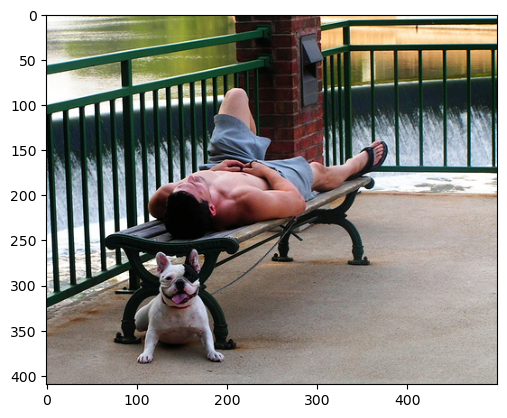

In [72]:
from PIL import Image
import matplotlib.pyplot as plt
# load image
image_name = "1003163366_44323f5815.jpg"
image_id = image_name.split('.')[0]
img_path = os.path.join(BASE_DIR, "Images", image_name)
image = Image.open(img_path)
captions = mapping[image_id]
print('---------Actual-----------')
for caption in captions:
    print(caption)
# predict
y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
print('--------------Predicted----------')
print(y_pred)
plt.imshow(image)